In [1]:
%run ./importLibraries.ipynb
%run ./setup.ipynb
%run ./displayImage.ipynb
#%run ./CNN_Encoder.ipynb
%run ./BioFaceUNet.ipynb
%run ./uploadImage.ipynb
%run ./scalingNet.ipynb
%run ./illuminationModel.ipynb
%run ./CameraModel.ipynb
%run ./computeLightColor.ipynb
%run ./computeSpecularities.ipynb
%run ./BiotoSpectralRef.ipynb
%run ./imageFormation.ipynb
%run ./whiteBalanced.ipynb
%run ./findT.ipynb
%run ./fromRawToRGB.ipynb
%run ./lossCalc.ipynb

cpu


In [2]:
from torch.utils.data import DataLoader

In [3]:
torch.cuda.empty_cache()

In [4]:
blossweight = 1e-4;  
appweight = 1e-3; 
Shadingweight = 1e-5; 
sparseweight = 1e-5;

In [5]:
imgDataV2 = loadImgV2("C:/Python/Python37/VMG_Candidate/img_align_celeba")

In [6]:
print(imgDataV2[0].shape)

torch.Size([3, 128, 128])


In [7]:
X_trainV2 = imgDataV2[:120] #80 works
X_testV2 = imgDataV2[120:136]
loadedImageData_trainV2 = {'train': DataLoader(X_trainV2,batch_size = 4, shuffle = False)}

In [8]:
bioFaceV2 = BioFaceUNet().to(device)
optimizerV2 = optim.SGD(bioFaceV2.parameters(),lr=0.001,momentum=0.9)

In [9]:
#for X in loadedImageData_trainV2['train']:
#    optimizerV2.zero_grad()
#    lightingParameters,b,fmel,fblood,shading,specmask = bioFaceV2(X)
#    weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,Shading,specmask = ScalingNet(lightingParameters,b,fmel,fblood,shading,specmask)
#    e = illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm)
#    Sr,Sg,Sb = cameraModel(mu,pc,b,33)
#    lightColor = computeLightColor(e, Sr, Sg, Sb)
#    Specularities = computeSpecularities(specmask,lightColor)
#    R_total = BiotoSpectralRef(fmel,fblood,newskincolour)
#    rawAppearance,diffuseAlbedo = ImageFormation(R_total, Sr,Sg,Sb,e,Specularities,Shading)
#    whiteBalanced = WhiteBalance(rawAppearance,lightColor)
#    T_RAW2XYZ = findT(Tmatrix,BGrid)
#    sRGBim = fromRawTosRGB(whiteBalanced,T_RAW2XYZ)

In [10]:
###run with loss
for epochRun in range(11):
    running_loss = 0.0
    for X in loadedImageData_trainV2['train']:
        optimizerV2.zero_grad()
        lightingParameters,b,fmel,fblood,shading,specmask = bioFaceV2(X)
        weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,Shading,specmask = ScalingNet(lightingParameters,b,fmel,fblood,shading,specmask)
        e = illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm)
        Sr,Sg,Sb = cameraModel(mu,pc,b,33)
        lightColor = computeLightColor(e, Sr, Sg, Sb)
        Specularities = computeSpecularities(specmask,lightColor)
        R_total = BiotoSpectralRef(fmel,fblood,newskincolour)
        rawAppearance,diffuseAlbedo = ImageFormation(R_total, Sr,Sg,Sb,e,Specularities,Shading)
        whiteBalanced = WhiteBalance(rawAppearance,lightColor)
        T_RAW2XYZ = findT(Tmatrix,BGrid)
        sRGBim = fromRawTosRGB(whiteBalanced,T_RAW2XYZ)
        
        #Loss
        bLoss = cameraLoss(b,blossweight)
        appLoss = appearanceLoss(X,sRGBim,appweight)
        sparsLoss = sparsityLoss(Specularities,sparseweight)
        loss = bLoss+appLoss+sparsLoss
        running_loss = running_loss+loss.item()
        loss.backward()
        optimizerV2.step()
    if epochRun%2 == 0:
        print("-----epoch: ",epochRun)
        print("Loss: ", running_loss/4)

c:\users\venen\onedrive\desktop\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
c:\users\venen\onedrive\desktop\python39\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
c:\users\venen\onedrive\desktop\python39\lib\site-packages\torch\nn\functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is des

-----epoch:  0
Loss:  12448833.899338357
-----epoch:  2
Loss:  157.26030917971997
-----epoch:  4
Loss:  157.26030917971997
-----epoch:  6
Loss:  157.26030917971997
-----epoch:  8
Loss:  157.26030917971997
-----epoch:  10
Loss:  157.26030917971997


In [25]:
loadedImageData_testV2 = {'test': DataLoader(X_testV2,batch_size = 4, shuffle = False)}

In [41]:
bioFaceV2.eval()
for X in loadedImageData_testV2['test']:
    lightingParameters,b,fmel,fblood,shading,specmask = bioFaceV2(X)
    weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,Shading,specmask = ScalingNet(lightingParameters,b,fmel,fblood,shading,specmask)

In [42]:
###displaying
fmel_disp = fmel[0].detach().numpy()
fblood_disp = fblood[0].detach().numpy()
shading_disp = shading[0].detach().numpy()
specmask_disp = specmask[0].detach().numpy()

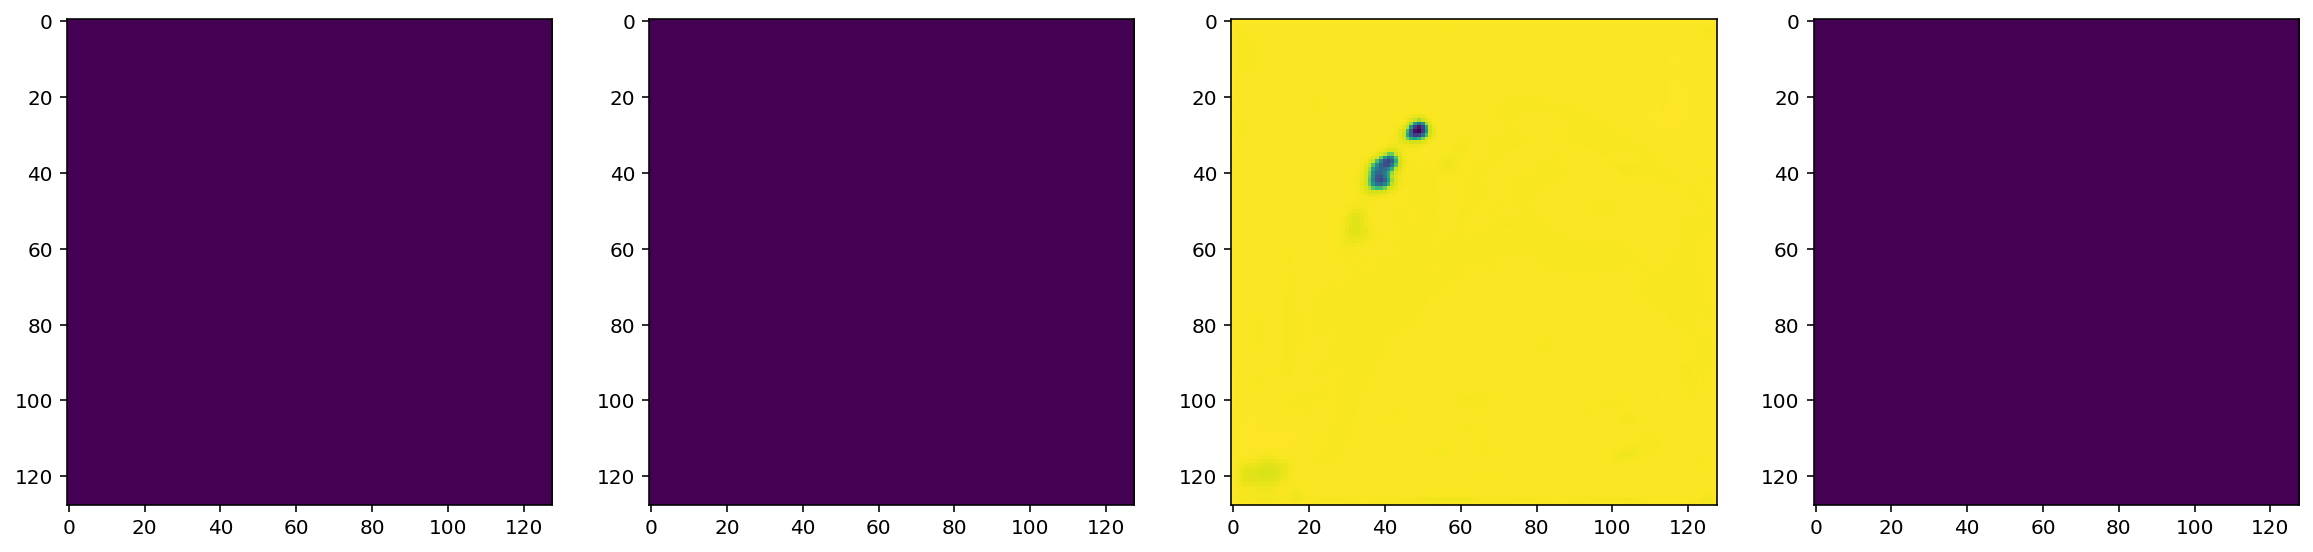

In [43]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
axs[0].imshow(fmel_disp)
axs[1].imshow(fblood_disp)
axs[2].imshow(shading_disp)
axs[3].imshow(specmask_disp)